# Simple PPO agent

This notebook provides an example of a quick training of [Proximal-Policy Optimization](https://arxiv.org/abs/1707.06347) (PPO) algorithm and of the loading of an existing trained agent on the `DamEnv` environment.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/media/samuele/Disco/PycharmProjectsUbuntu/gym4ReaL


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tqdm import tqdm
import torch

import gymnasium as gym
from gymnasium.wrappers import RescaleAction

from skrl.agents.torch.ppo import PPO, PPO_DEFAULT_CONFIG
from skrl.envs.wrappers.torch import wrap_env
from skrl.memories.torch import RandomMemory
from skrl.resources.preprocessors.torch import RunningStandardScaler
from skrl.resources.schedulers.torch import KLAdaptiveRL
from skrl.trainers.torch import SequentialTrainer
from skrl.utils import set_seed

from gym4real.envs.dam.utils import parameter_generator
from gym4real.algorithms.dam.ppo_skrl import Policy, Value

In [3]:
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context("paper")
plot_colors = sns.color_palette('colorblind')
sns.set(font_scale=1.2)

alg_color = {
    'ppo_quick': plot_colors[1],
    'ppo_pretrained': plot_colors[2]
}

alg_labels = {
    'ppo_quick': 'PPO quick',
    'ppo_pretrained': 'PPO pretrained'
}

In [4]:
n_episodes = 13
rewards = {}

In [5]:
eval_params = parameter_generator(
    world_options='gym4real/envs/dam/world_test.yaml',
    lake_params='gym4real/envs/dam/lake.yaml'
)

eval_env = gym.make('gym4real/dam-v0', settings=eval_params)
scaled_eval_env = RescaleAction(eval_env, min_action=-1., max_action=1.)
scaled_eval_env = wrap_env(scaled_eval_env)

/media/samuele/Disco/PycharmProjectsUbuntu/gym4ReaL/.venv/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/media/samuele/Disco/PycharmProjectsUbuntu/gym4ReaL/.venv/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
[skrl:INFO] Environment wrapper: 'auto' (class: gymnasium.core.Env, gymnasium.utils.record_constructor.RecordConstructorArgs, gymnasium.wrappers.transform_action.TransformAction)
[skrl:INFO] Environment wrapper: gymnasium
[skrl:WARNING] Failed to check for a vectorized environment: module 'gymnasium.experimental' has no attribute 'vector'


## Training

Here we will provide an example of a very quick training

In [6]:
params = parameter_generator(
    world_options='gym4real/envs/dam/world_train.yaml',
    lake_params='gym4real/envs/dam/lake.yaml'
)

env = gym.make('gym4real/dam-v0', settings=params)
env = RescaleAction(env, min_action=-1., max_action=1.)
env = wrap_env(env)

/media/samuele/Disco/PycharmProjectsUbuntu/gym4ReaL/.venv/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/media/samuele/Disco/PycharmProjectsUbuntu/gym4ReaL/.venv/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
[skrl:INFO] Environment wrapper: 'auto' (class: gymnasium.core.Env, gymnasium.utils.record_constructor.RecordConstructorArgs, gymnasium.wrappers.transform_action.TransformAction)
[skrl:INFO] Environment wrapper: gymnasium
[skrl:WARNING] Failed to check for a vectorized environment: module 'gymnasium.experimental' has no attribute 'vector'


In [7]:
set_seed(123)
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_arch = (16, 16)

memory = RandomMemory(memory_size=2048, num_envs=env.num_envs, device=device)

models = {}
models["policy"] = Policy(env.observation_space, env.action_space, device=device, net_arch=net_arch, initial_log_std=-0.5)#, clip_actions=True)
models["value"] = Value(env.observation_space, env.action_space, device=device, net_arch=net_arch)

cfg = PPO_DEFAULT_CONFIG.copy()
cfg["rollouts"] = 2048
cfg["learning_epochs"] = 10
cfg["mini_batches"] = 32
cfg["discount_factor"] = 0.995
cfg["lambda"] = 0.95
cfg["learning_rate"] = 8e-6
cfg["learning_rate_scheduler"] = KLAdaptiveRL
cfg["learning_rate_scheduler_kwargs"] = {"kl_threshold": 0.008}
cfg["grad_norm_clip"] = 0.5
cfg["ratio_clip"] = 0.2
cfg["value_clip"] = 0.2
cfg["clip_predicted_values"] = False
cfg["entropy_loss_scale"] = 0.
cfg["value_loss_scale"] = 0.5
cfg["kl_threshold"] = 0
cfg["mixed_precision"] = True
cfg["state_preprocessor"] = RunningStandardScaler
cfg["state_preprocessor_kwargs"] = {"size": env.observation_space, "device": device}
cfg["value_preprocessor"] = RunningStandardScaler
cfg["value_preprocessor_kwargs"] = {"size": 1, "device": device}
# logging to TensorBoard and write checkpoints (in timesteps)
cfg["experiment"]["write_interval"] = 500
# cfg["experiment"]['experiment_name'] = args['exp_name']
cfg["experiment"]["checkpoint_interval"] = 500
cfg["experiment"]["directory"] = "examples/dam/trained_agents/quick"

agent = PPO(models=models,
            memory=memory,
            cfg=cfg,
            observation_space=env.observation_space,
            action_space=env.action_space,
            device=device
            )

cfg_trainer = {"timesteps": 2000, "headless": True}
trainer = SequentialTrainer(cfg=cfg_trainer, env=env, agents=[agent])
agent.set_mode("eval")

[skrl:INFO] Seed: 123


In [8]:
trainer.train()

100%|██████████| 2000/2000 [00:05<00:00, 360.89it/s]


### Testing

Here we will test the agent we just trained

In [9]:
alg = 'ppo_quick'
rewards[alg] = []


scaled_eval_env.curr_year_data = None

with torch.no_grad():

    for episode in tqdm(range(n_episodes)):
        obs, info = scaled_eval_env.reset()
        done = False
        rewards_episode = []
        timesteps = 0
        while not done:
            output = agent.act(obs, timesteps, 365)
            action = output[-1]['mean_actions']
            obs, reward, terminated, truncated, info = scaled_eval_env.step(action)  # Return observation and reward
            done = terminated or truncated
            rewards_episode.append(info['weighted_reward'])
            timesteps += 1

        rewards[alg].append(rewards_episode)


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


## Pretrained agent

Here we will load and test a pretrained PPO agent from file

In [10]:
# The agent was trained with the same structure of the one we just quicly trained, so we can use the same parameters
agent_pretrained = PPO(models=models,
                      memory=memory,
                      cfg=cfg,
                      observation_space=env.observation_space,
                      action_space=env.action_space,
                      device=device
                      )

agent_pretrained.load('examples/dam/trained_agents/agent_200000.pt')

In [11]:
alg = 'ppo_pretrained'
rewards[alg] = []


scaled_eval_env.curr_year_data = None

with torch.no_grad():

    for episode in tqdm(range(n_episodes)):
        obs, info = scaled_eval_env.reset()
        done = False
        rewards_episode = []
        timesteps = 0
        while not done:
            output = agent_pretrained.act(obs, timesteps, 365)
            action = output[-1]['mean_actions']
            obs, reward, terminated, truncated, info = scaled_eval_env.step(action)  # Return observation and reward
            done = terminated or truncated
            rewards_episode.append(info['weighted_reward'])
            timesteps += 1

        rewards[alg].append(rewards_episode)

100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


# Plotting

In [12]:
# convert, for all policies, from list of dicts to dict of arrays
rewards = {key: [{
        r_type: np.array([prof[i][r_type] for i in range(len(prof))]) for r_type in prof[0].keys()
    } for prof in rewards[key]] for key in rewards.keys()
}

In [13]:
rewards_types_to_plot = ['overflow_reward', 'starving_reward', 'daily_deficit_reward']

rewards_to_plot = {key: [sum([prof[r_type] for r_type in rewards_types_to_plot]) for prof in rewards[key]] for key in rewards.keys()}
cum_rewards = {key: [np.cumsum(prof) for prof in val] for key, val in rewards_to_plot.items()}

Text(0, 0.5, 'Total objective reward')

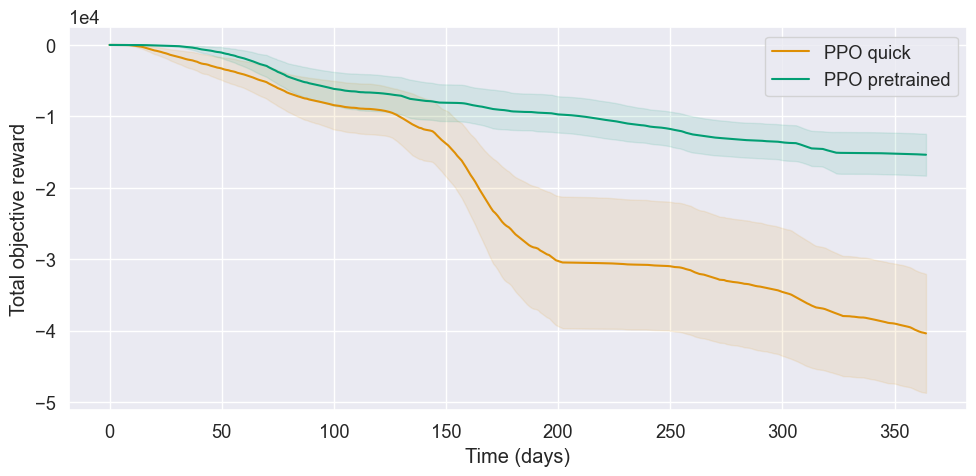

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), tight_layout=True)

for alg in cum_rewards.keys():
    means = np.mean(cum_rewards[alg], axis=0)
    stds = np.std(cum_rewards[alg], axis=0)
    ci = 1.96 * stds/np.sqrt(len(cum_rewards[alg]))

    ax.plot(means, label=alg_labels[alg], color=alg_color[alg])
    ax.fill_between(range(len(means)), means + ci, means - ci, color=alg_color[alg], alpha=0.1)
    ax.legend()

ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax.set_xlabel('Time (days)')
ax.set_ylabel('Total objective reward')